In [80]:
import pandas as pd
import numpy as np
import feather
import pickle
import re
from polyfuzz import PolyFuzz
from polyfuzz.models import EditDistance, TFIDF, Embeddings
from flair.embeddings import TransformerWordEmbeddings

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load Main Ticket Data

In [2]:
ticket20 = feather.read_dataframe('ticket_2020.feather')
ticket19 = feather.read_dataframe('ticket_2019.feather')

## Get Street Code:Street Name DIctionary

In [21]:
# get street name dictionary
stnames = pd.read_csv('/Users/stuartong/uberticketsyelp/Data/snd20d/snd20Dcow.txt')
stnames.columns = ['Raw']

# from SND_metadata.pdf - location of stnames and Lookup prefixes
stnames['Street Name'] = stnames['Raw'].str[2:34].str.strip()
stnames['Lookup'] = stnames['Raw'].str[34:42]

# only keep primary names
stnames = stnames[stnames['Lookup'].str.contains('PF')]

# create streetname dictionary
stnames_dict= pd.Series(stnames['Street Name'].values,index=stnames['Lookup']).to_dict()


,Raw,Street Name,Lookup
0,11 0 BOND STREET PF1006890101...,0 BOND STREET,PF100689
1,11 1 AVENUE PF1100100101...,1 AVENUE,PF110010
2,11 1 AVENUE LOOP PF1317200102...,1 AVENUE LOOP,PF131720
5,11 1 AVENUE TUNNEL PF1011270101...,1 AVENUE TUNNEL,PF101127
7,11 1 DRIVE PF1136550101...,1 DRIVE,PF113655
11,11 1 PLACE PF1100150101...,1 PLACE,PF110015
13,11 1 PRECINCT STATIONHOUSE PF1000580106...,1 PRECINCT STATIONHOUSE,PF100058
21,11 2 AVENUE PF1101100101...,2 AVENUE,PF110110
36,11 2 DRIVE PF1134700101...,2 DRIVE,PF113470
37,11 2 PLACE PF1101150101...,2 PLACE,PF110115


## Clean Ticket Data - First Pass

See function description for cleaning details

In [26]:
def clean_tickets(df):
    '''This function is for cleaning ticket dataframes and to do the following:
    1. Map a clean violation description based on violation code
    2. Map a borocode from violation county
    3. Add leading zeros back to street code - to ensure 5 digit
    4. Create street code lookup string following SND_metadata.pdf pattern
    5. Get primary/clean street names from stnames_dict
        Note: 
            - Street 1 is main street where violation occured 
            - Street 2/3 represents intersecting streets to mark out the section of street 1
    6. Clean primary street names for better BERT matching
        a. Strip excess white spaces
        b. replace East/West XXX Street to E/W XXX ST
    '''
    # 1. get violation codes/dictionary
    violation_codes =pd.read_json("https://data.cityofnewyork.us/resource/ncbg-6agr.json")
    violation_dict = violation_codes.set_index('code').to_dict()['definition']
    
    # 1. map violation description
    df['Clean Violation Des'] = df['Violation Code'].map(violation_dict)
    
    # 2. create boro_dict
    boro_dict = {'NY':'1',
                 'MN':'1',
                 'BX':'2',
                 'K':'3',
                 'K F':'3',
                 'BK':'3',
                 'KINGS':'3',
                 'Q':'4',
                 'P' : '0',
                 'QN':'4',
                 'QUEEN':'4',
                 'QNS':'4',
                 'R':'5',
                 'ST':'5',
                 'None':'0'
                }
    
    # 2. map boro code
    df['Boro Code'] = df['Violation County'].map(boro_dict)
    
    
    # 3. Add back leading zeros to street code
    df['Street Code1'] = df['Street Code1'].apply('{0:0>5}'.format)
    df['Street Code2'] = df['Street Code2'].apply('{0:0>5}'.format)
    df['Street Code3'] = df['Street Code3'].apply('{0:0>5}'.format)
    
    # 4. Create Street Code Lookup String
    df['Street1LU'] = 'PF'+df['Boro Code']+df['Street Code1']
    df['Street2LU'] = 'PF'+df['Boro Code']+df['Street Code2']
    df['Street3LU'] = 'PF'+df['Boro Code']+df['Street Code3']
    
    
    # 5. Match Street Codes to Primary Street Name
    df['Street1'] = df['Street1LU'].map(stnames_dict)
    df['Street2'] = df['Street2LU'].map(stnames_dict)
    df['Street3'] = df['Street3LU'].map(stnames_dict)
    
    # 6. Clean Street Names for better BERT matching
    
    # clean white space
    df['Street1Clean'] = df['Street1'].str.replace(' +',' ',regex=True)
    df['Street2Clean'] = df['Street2'].str.replace(' +',' ',regex=True)
    df['Street3Clean'] = df['Street3'].str.replace(' +',' ',regex=True)
    
    # standardize some common street name patterns
    df['Street1Clean']=df['Street1Clean'].str.replace(r"(EAST) ([0-9]+) (STREET)",'E \g<2> ST',regex=True)
    df['Street1Clean']=df['Street1Clean'].str.replace(r"(WEST) ([0-9]+) (STREET)",'W \g<2> ST',regex=True)
    df['Street2Clean']=df['Street2Clean'].str.replace(r"(EAST) ([0-9]+) (STREET)",'E \g<2> ST',regex=True)
    df['Street2Clean']=df['Street2Clean'].str.replace(r"(WEST) ([0-9]+) (STREET)",'W \g<2> ST',regex=True)
    df['Street3Clean']=df['Street3Clean'].str.replace(r"(EAST) ([0-9]+) (STREET)",'E \g<2> ST',regex=True)
    df['Street3Clean']=df['Street3Clean'].str.replace(r"(WEST) ([0-9]+) (STREET)",'W \g<2> ST',regex=True)
    
    # ADD MORE ABOVE HERE IF REQUIRED - remember to add for Street 1 street 2 street 3
    
    
    return df

## Run clean_tickets on ticket20 and ticket19 dataframes

In [29]:
ticket20_clean=clean_tickets(ticket20)
ticket19_clean=clean_tickets(ticket19)

In [32]:
ticket20_clean.head(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Clean Violation Des,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3,Street1Clean,Street2Clean,Street3Clean
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,NO STANDING-EXC. TRUCK LOADING,3,PF308730,PF305130,PF305280,43 STREET,2 AVENUE,3 AVENUE,43 STREET,2 AVENUE,3 AVENUE
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,OBSTRUCTING DRIVEWAY,3,PF386530,PF371800,PF373110,UNION STREET,PORTAL STREET,RALPH AVENUE,UNION STREET,PORTAL STREET,RALPH AVENUE
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,NO PARKING-DAY/TIME LIMITS,3,PF327030,PF341330,PF369230,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF333030,PF393630,PF358730,DIVISION AVENUE,WILSON STREET,MARCY AVENUE,DIVISION AVENUE,WILSON STREET,MARCY AVENUE
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF345130,PF323930,PF368130,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET


In [33]:
ticket19_clean.head(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Clean Violation Des,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3,Street1Clean,Street2Clean,Street3Clean
0,1442479747,HCP7926,NY,PAS,07/16/2018,21,SDN,ME/BE,S,00000,00000,00000,20191023,73.0,73,0,637090,KN16,0000,0753A,None,K,None,None,N/S TRUXTON ST,W/O CONWAY ST,0,408,D1,None,YBBYBBB,0730A,0800A,RED,0.0,2016,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF300000,PF300000,PF300000,NaN,NaN,NaN,NaN,NaN,NaN
1,1442479759,HSZ2472,NY,PAS,07/13/2018,21,SUBN,ME/BE,S,49230,56630,73380,20190717,73.0,73,0,637090,KN16,0000,1157A,None,K,F,343,HERZL ST,None,0,408,D1,None,BYBBYBB,1130A,0100P,TAN,0.0,2003,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF349230,PF356630,PF373380,HERZL STREET,LIVONIA AVENUE,RIVERDALE AVENUE,HERZL STREET,LIVONIA AVENUE,RIVERDALE AVENUE
2,1442479772,HYJ1988,NY,PAS,07/13/2018,21,SUBN,HONDA,S,12430,56630,00000,20200226,73.0,73,0,637090,KN16,0000,1205P,None,K,None,None,AMBOY ST,LIVONIA AVE,0,408,D1,None,BYBBYBB,1130A,0100P,GREY,0.0,2018,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF312430,PF356630,PF300000,AMBOY STREET,LIVONIA AVENUE,NaN,AMBOY STREET,LIVONIA AVENUE,NaN
3,1442480397,HNV6246,NY,PAS,07/13/2018,21,SUBN,TOYOT,S,83730,74730,72030,20200125,73.0,73,0,686917,KN16,0000,0916A,None,K,O,410,SUTTER AVE,None,0,408,D1,None,BYBBYBB,0900A,1030A,BLUE,0.0,2005,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF383730,PF374730,PF372030,SUTTER AVENUE,SACKMAN STREET,POWELL STREET,SUTTER AVENUE,SACKMAN STREET,POWELL STREET
4,1442480403,HWG4025,NY,PAS,07/13/2018,21,SUBN,HYUND,S,83730,74730,72030,20191103,73.0,73,0,686917,KN16,0000,0918A,None,K,O,410,SUTTER AVE,None,0,408,D1,None,BYBBYBB,0900A,1030A,GREEN,0.0,2010,-,0,None,None,NaN,NaN,NaN,NO PARKING-STREET CLEANING,3,PF383730,PF374730,PF372030,SUTTER AVENUE,SACKMAN STREET,POWELL STREET,SUTTER AVENUE,SACKMAN STREET,POWELL STREET


## Load and Clean Centerline Data

In [34]:
cl_df= pd.read_csv('/Users/stuartong/uberticketsyelp/Data/Centerline.csv')

# note some address contain '-' we only want the portion before the dash
cl_df['l_lowadd']=cl_df['L_LOW_HN'].str.split('-').str[0]
cl_df['l_highadd']=cl_df['L_HIGH_HN'].str.split('-').str[0]
cl_df['r_lowadd']=cl_df['R_LOW_HN'].str.split('-').str[0]
cl_df['r_highadd']=cl_df['R_HIGH_HN'].str.split('-').str[0]

# note have issues with none types convert to np.nan 
# we do this as some sides of the street do not have an address - i.e. 0 - so that we can evaluate the min

cl_df['r_lowadd'].replace({'0':np.nan},inplace=True)
cl_df['l_lowadd'].replace({'0':np.nan},inplace=True)
cl_df['c_lowadd']= cl_df[['l_lowadd','r_lowadd']].min(axis=1,skipna=True)
cl_df['c_highadd']=cl_df[['l_highadd','r_highadd']].max(axis=1)

cl_df.head(10)

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
0,MULTILINESTRING ((-73.87861544017795 40.861915...,NaN,164809,NaN,NaN,NaN,10458.0,10458.0,0,0,MITSUBISHI WILD WETLAND TRL,2,NaN,2,0,08/19/2014 12:00:00 AM +0000,12/22/2015 12:00:00 AM +0000,NV,6,13,13,NaN,NaN,NaN,NaN,TRL,NaN,NaN,MITSUBISHI WILD WETLAND TRL,MITSUBISHI WILD WETLAND,NaN,1026.077523,NaN,NaN,NaN,NaN,NaN,NaN
1,MULTILINESTRING ((-73.7729030190404 40.7778042...,215-001,6110,215-027,215-000,215-026,11360.0,11360.0,112261166,112262650,28 AVE,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,28 AVE,28,NaN,258.859740,215.0,215,215.0,215,215.0,215.0
2,MULTILINESTRING ((-73.90711253281893 40.905186...,5631,61140,5699,5602,5698,10471.0,10471.0,1522604870,1522601877,ARLINGTON AVE,2,NaN,2,42,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,H,NaN,NaN,NaN,AVE,NaN,NaN,ARLINGTON AVE,ARLINGTON,NaN,454.932922,5631.0,5699,5602.0,5698,5602.0,5699.0
3,MULTILINESTRING ((-73.98181677514282 40.687329...,317,145494,399,316,360,11217.0,11217.0,1922603730,1922612977,SCHERMERHORN ST,2,2.0,3,50,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,SCHERMERHORN ST,SCHERMERHORN,TW,609.424375,317.0,399,316.0,360,316.0,399.0
4,MULTILINESTRING ((-73.8300230194527 40.7140059...,120-011,12438,120-011,0,0,11415.0,11415.0,92261717,92269521,QUEENS BLVD,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,QUEENS BLVD,QUEENS,NaN,47.399228,120.0,120,NaN,0,120.0,120.0
5,MULTILINESTRING ((-74.15825784169094 40.562201...,528,15432,554,555,555,10308.0,10308.0,1722611503,1722601588,ARTHUR KILL RD,2,NaN,5,36,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,RD,NaN,NaN,ARTHUR KIL RD,ARTHUR KIL,NaN,268.228751,528.0,554,555.0,555,528.0,555.0
6,MULTILINESTRING ((-73.8871122884414 40.8484154...,731,52620,759,730,758,10457.0,10457.0,1522611738,1522610770,E 181 ST,2,NaN,2,30,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TF,1,13,13,S,NaN,E,NaN,ST,NaN,NaN,E 181 ST,181,NaN,360.814869,731.0,759,730.0,758,730.0,759.0
7,MULTILINESTRING ((-73.90674661427755 40.736717...,51-001,83272,51-099,51-000,51-098,11377.0,11377.0,102264679,102265638,58 LN,2,NaN,4,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,LN,NaN,NaN,58 LN,58,NaN,625.213984,51.0,51,51.0,51,51.0,51.0
8,MULTILINESTRING ((-73.90098639497059 40.702449...,68-049,26405,68-099,68-050,68-098,11385.0,11385.0,52263275,52261376,FOREST AVE,2,NaN,4,36,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,AVE,NaN,NaN,FOREST AVE,FOREST,NaN,260.293103,68.0,68,68.0,68,68.0,68.0
9,MULTILINESTRING ((-74.23944088631606 40.529011...,0,95944,0,15,15,10309.0,10309.0,1722607326,1722611776,TIDES LN,2,NaN,5,34,11/29/2007 12:00:00 AM +0000,10/07/2020 12:00:00 AM +0000,TW,1,13,13,V,NaN,NaN,NaN,LN,NaN,NaN,TIDES LN,TIDES,NaN,113.491099,NaN,0,15.0,15,15.0,15.0


## Fuzzy String Match Using BERT for Street Names

### To map ticket street names to centerline street names

We will build a BERT for each boro and match for better accuracy 

In [35]:
# Create seperate from and to list by Boro for better match accuracy

# takes just over an hour to run 10 BERT models - so we save them to memory 

# UNCOMMENT EVERYTHING BELOW HERE TO RERUN THE BERT FUZZY MATCH 


# from_list_b1=ticket20_clean[ticket20_clean['Boro Code']=='1']['Street1Clean'].dropna().unique().tolist()
# from_list_b2=ticket20_clean[ticket20_clean['Boro Code']=='2']['Street1Clean'].dropna().unique().tolist()
# from_list_b3=ticket20_clean[ticket20_clean['Boro Code']=='3']['Street1Clean'].dropna().unique().tolist()
# from_list_b4=ticket20_clean[ticket20_clean['Boro Code']=='4']['Street1Clean'].dropna().unique().tolist()
# from_list_b5=ticket20_clean[ticket20_clean['Boro Code']=='5']['Street1Clean'].dropna().unique().tolist()

# from_list_b12=ticket19_clean[ticket19_clean['Boro Code']=='1']['Street1Clean'].dropna().unique().tolist()
# from_list_b22=ticket19_clean[ticket19_clean['Boro Code']=='2']['Street1Clean'].dropna().unique().tolist()
# from_list_b32=ticket19_clean[ticket19_clean['Boro Code']=='3']['Street1Clean'].dropna().unique().tolist()
# from_list_b42=ticket19_clean[ticket19_clean['Boro Code']=='4']['Street1Clean'].dropna().unique().tolist()
# from_list_b52=ticket19_clean[ticket19_clean['Boro Code']=='5']['Street1Clean'].dropna().unique().tolist()

# match_list_b1 = cl_df[cl_df['BOROCODE']==1]['FULL_STREE'].unique().tolist()
# match_list_b2 = cl_df[cl_df['BOROCODE']==2]['FULL_STREE'].unique().tolist()
# match_list_b3 = cl_df[cl_df['BOROCODE']==3]['FULL_STREE'].unique().tolist()
# match_list_b4 = cl_df[cl_df['BOROCODE']==4]['FULL_STREE'].unique().tolist()
# match_list_b5 = cl_df[cl_df['BOROCODE']==5]['FULL_STREE'].unique().tolist()


# # 'Pipeline' to run Bert/tfidf/edit for each boro

# embeddings = TransformerWordEmbeddings('bert-base-multilingual-cased')
# bert = Embeddings(embeddings, min_similarity=0,model_id="BERT")
# tfidf = TFIDF(min_similarity=0,model_id='TF-IDF')
# edit = EditDistance(model_id='EDIT_DIST')
# string_models = [bert, tfidf, edit]


# model_b1 = PolyFuzz(string_models)
# model_b1.match(from_list_b1, match_list_b1)

# model_b2 = PolyFuzz(string_models)
# model_b2.match(from_list_b2, match_list_b2)

# model_b3 = PolyFuzz(string_models)
# model_b3.match(from_list_b3, match_list_b3)

# model_b4 = PolyFuzz(string_models)
# model_b4.match(from_list_b4, match_list_b4)

# model_b5 = PolyFuzz(string_models)
# model_b5.match(from_list_b5, match_list_b5)

# model_b12 = PolyFuzz(string_models)
# model_b12.match(from_list_b12, match_list_b1)

# model_b22 = PolyFuzz(string_models)
# model_b22.match(from_list_b22, match_list_b2)

# model_b32 = PolyFuzz(string_models)
# model_b32.match(from_list_b32, match_list_b3)

# model_b42 = PolyFuzz(string_models)
# model_b42.match(from_list_b42, match_list_b4)

# model_b52 = PolyFuzz(string_models)
# model_b52.match(from_list_b52, match_list_b5)

# pickle.dump(model_b1, open('BERT Models/model_b1_2020.sav','wb'))
# pickle.dump(model_b2, open('BERT Models/model_b2_2020.sav','wb'))
# pickle.dump(model_b3, open('BERT Models/model_b3_2020.sav','wb'))
# pickle.dump(model_b4, open('BERT Models/model_b4_2020.sav','wb'))
# pickle.dump(model_b5, open('BERT Models/model_b5_2020.sav','wb'))
# pickle.dump(model_b12, open('BERT Models/model_b1_2019.sav','wb'))
# pickle.dump(model_b22, open('BERT Models/model_b2_2019.sav','wb'))
# pickle.dump(model_b32, open('BERT Models/model_b3_2019.sav','wb'))
# pickle.dump(model_b42, open('BERT Models/model_b4_2019.sav','wb'))
# pickle.dump(model_b52, open('BERT Models/model_b5_2019.sav','wb'))


In [ ]:
# Load saved models to save time

model_b1 = pickle.load(open('BERT Models/model_b1_2020.sav','rb'))
model_b2 = pickle.load(open('BERT Models/model_b2_2020.sav','rb'))
model_b3 = pickle.load(open('BERT Models/model_b3_2020.sav','rb'))
model_b4 = pickle.load(open('BERT Models/model_b4_2020.sav','rb'))
model_b5 = pickle.load(open('BERT Models/model_b5_2020.sav','rb'))
model_b12 = pickle.load(open('BERT Models/model_b1_2019.sav','rb'))
model_b22 = pickle.load(open('BERT Models/model_b2_2019.sav','rb'))
model_b32 = pickle.load(open('BERT Models/model_b3_2019.sav','rb'))
model_b42 = pickle.load(open('BERT Models/model_b4_2019.sav','rb'))
model_b52 = pickle.load(open('BERT Models/model_b5_2019.sav','rb'))

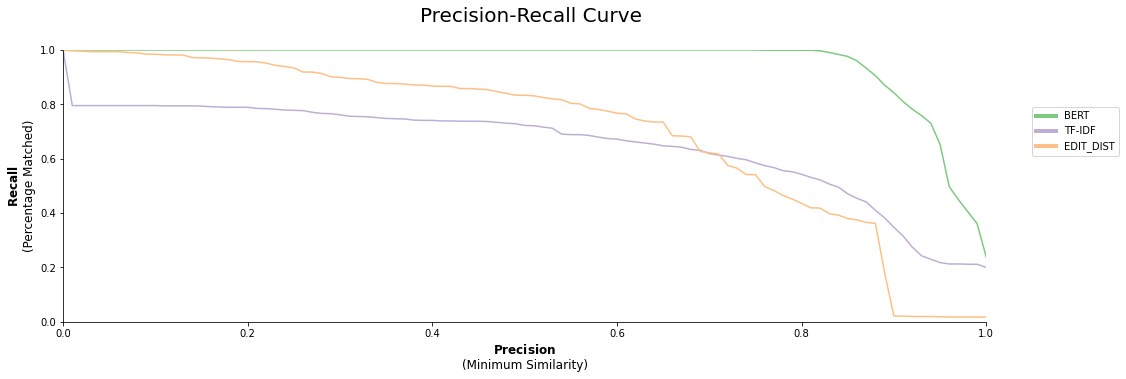

In [55]:
model_b1.visualize_precision_recall()

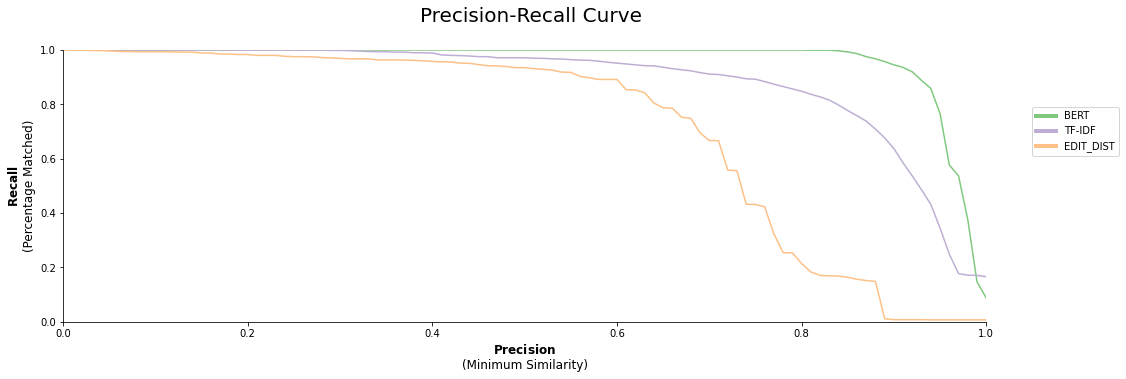

In [56]:
model_b2.visualize_precision_recall()

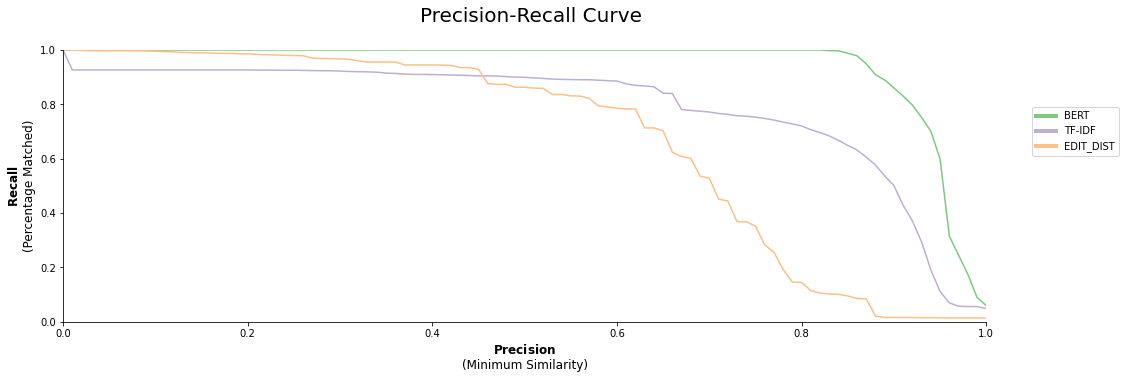

In [57]:
model_b3.visualize_precision_recall()

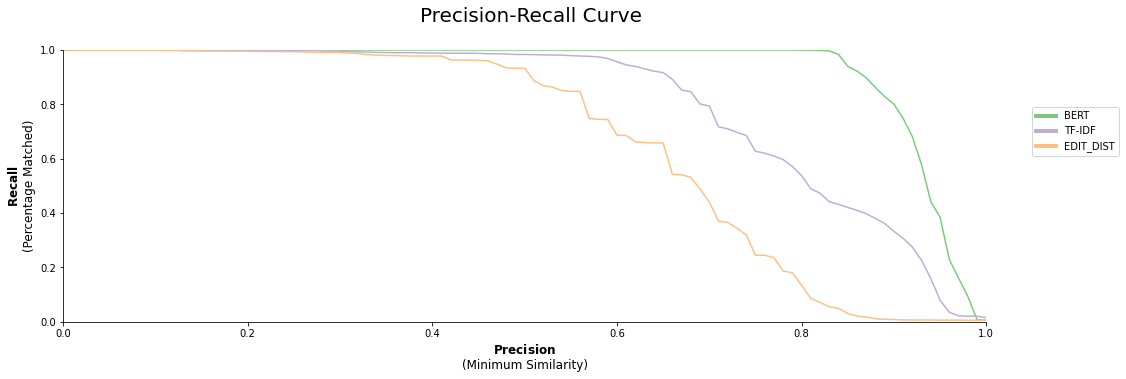

In [58]:
model_b4.visualize_precision_recall()

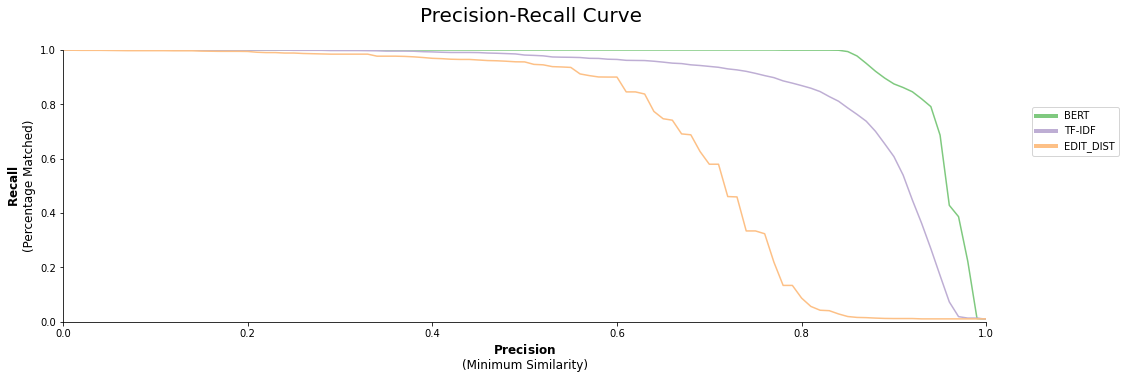

In [59]:
model_b5.visualize_precision_recall()

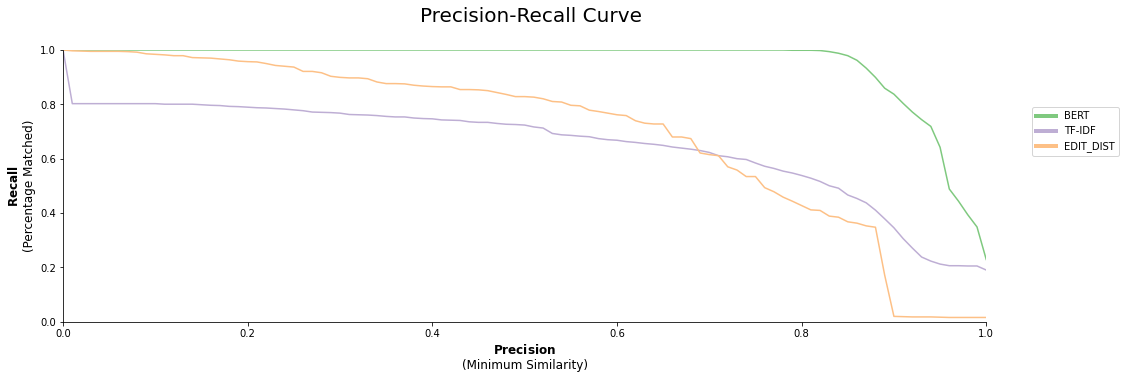

In [60]:
model_b12.visualize_precision_recall()

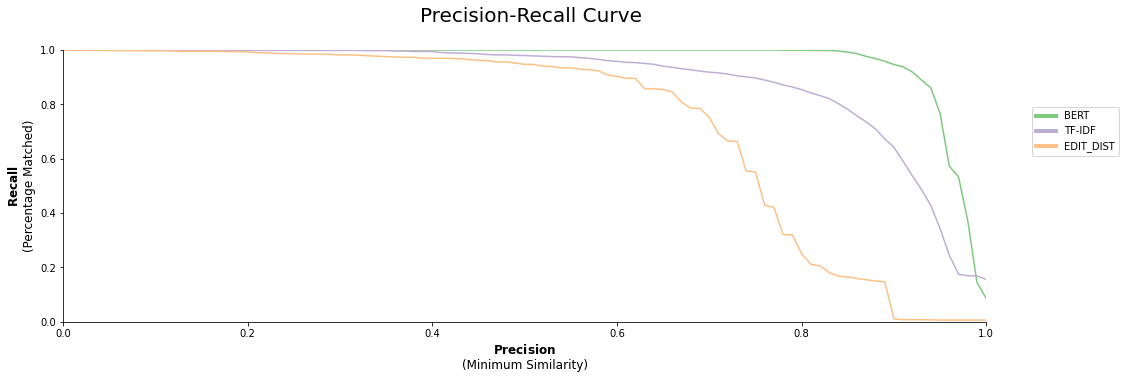

In [61]:
model_b22.visualize_precision_recall()

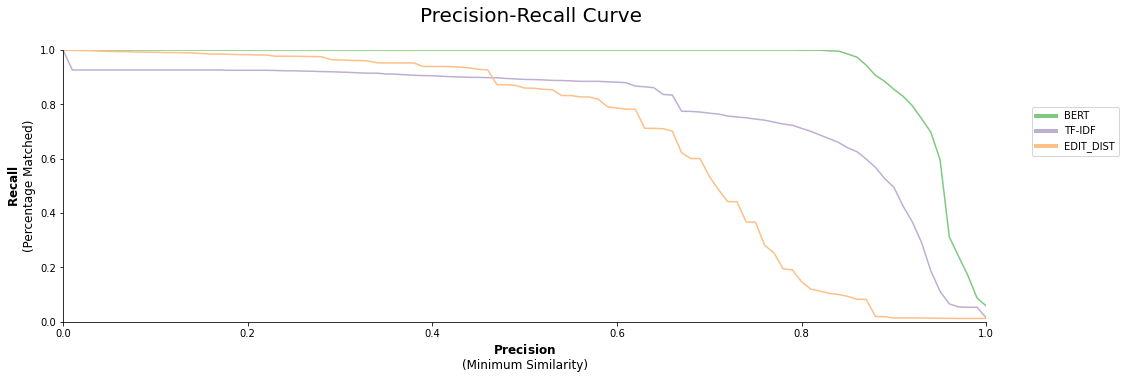

In [62]:
model_b32.visualize_precision_recall()

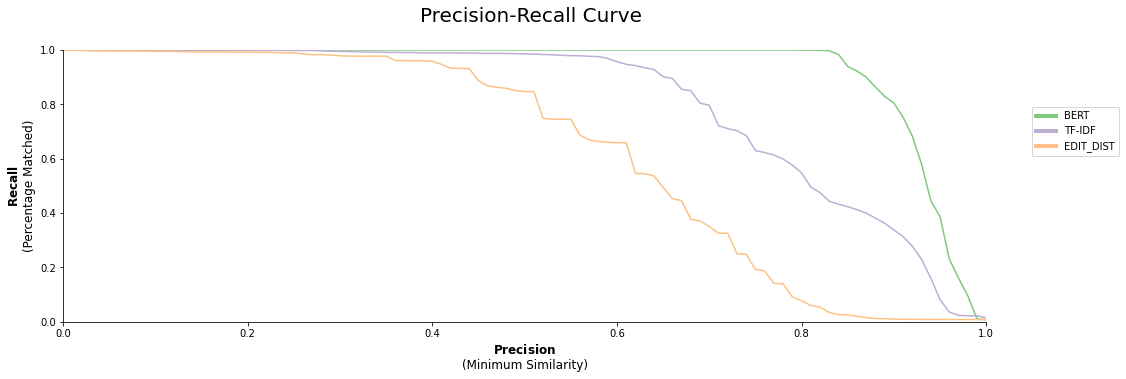

In [63]:
model_b42.visualize_precision_recall()

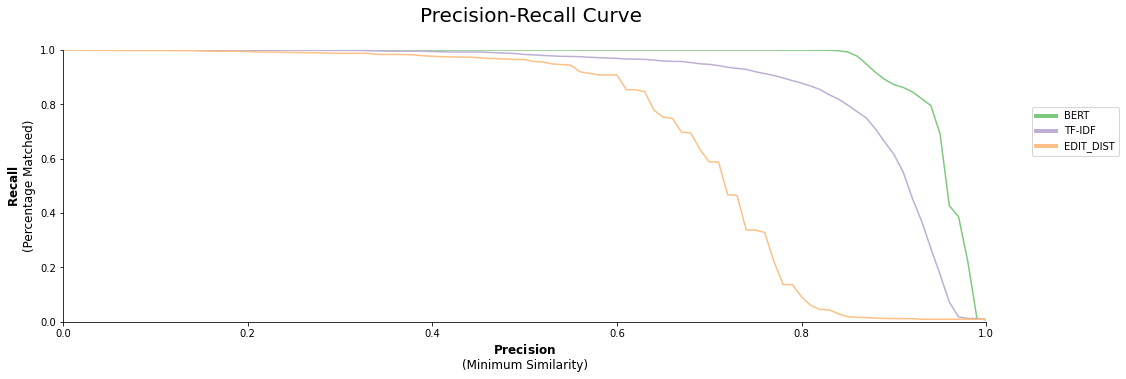

In [64]:
model_b52.visualize_precision_recall()

In [69]:
# get match results

match20b1 = model_b1.get_matches('BERT')
match20b2 = model_b2.get_matches('BERT')
match20b3 = model_b3.get_matches('BERT')
match20b4 = model_b4.get_matches('BERT')
match20b5 = model_b5.get_matches('BERT')

match19b1 = model_b12.get_matches('BERT')
match19b2 = model_b22.get_matches('BERT')
match19b3 = model_b32.get_matches('BERT')
match19b4 = model_b42.get_matches('BERT')
match19b5 = model_b52.get_matches('BERT')

In [73]:
# get counts of violations for each street 

count20b1 = ticket20_clean[ticket20_clean['Boro Code']=='1'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count20b2 = ticket20_clean[ticket20_clean['Boro Code']=='2'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count20b3 = ticket20_clean[ticket20_clean['Boro Code']=='3'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count20b4 = ticket20_clean[ticket20_clean['Boro Code']=='4'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count20b5 = ticket20_clean[ticket20_clean['Boro Code']=='5'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']

count19b1 = ticket19_clean[ticket19_clean['Boro Code']=='1'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count19b2 = ticket19_clean[ticket19_clean['Boro Code']=='2'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count19b3 = ticket19_clean[ticket19_clean['Boro Code']=='3'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count19b4 = ticket19_clean[ticket19_clean['Boro Code']=='4'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']
count19b5 = ticket19_clean[ticket19_clean['Boro Code']=='5'].groupby('Street1Clean').agg({'Summons Number':'count'}).sort_values(by=['Summons Number'],ascending=False).to_dict()['Summons Number']


In [78]:
match = [match20b1,
         match20b2,
         match20b3,
         match20b4,
         match20b5,
         match19b1,
         match19b2,
         match19b3,
         match19b4,
         match19b5
        ]

count = [count20b1,
         count20b2,
         count20b3,
         count20b4,
         count20b5,
         count19b1,
         count19b2,
         count19b3,
         count19b4,
         count19b5 
        ]

for i,j in zip (match,count):
    i['No of Violations'] = i['From'].map(j)
    totalviolations = i['No of Violations'].sum()
    i['Proportion of total'] = i['No of Violations']/totalviolations 
    i.sort_values(by=['No of Violations'],ascending=False,inplace=True)

In [86]:
match20b1

,From,To,Similarity,No of Violations,Proportion of total
13,BROADWAY,BROADWAY,1.000,142700,0.045
34,3 AVENUE,3 AVE,0.956,114616,0.036
15,2 AVENUE,2 AVE,0.958,84090,0.027
16,MADISON AVENUE,MADISON AVE,0.982,80687,0.025
63,LEXINGTON AVENUE,LENOX AVE,0.947,66174,0.021
...,...,...,...,...,...
929,DE WITT CLINTON PARK,GEORGE WASHINGTON BRDG BIKE PATH,0.891,1,0.000
936,KIMMEL ROAD,KIMLOW SQ,0.879,1,0.000
905,SHELTERING ARMS PARK,HIGH BRIDGE PARK PATH,0.886,1,0.000
952,ST AGNES BOYS HIGH SCHOOL,UNIVERSITY HEIGHTS BR BIKE PATH,0.898,1,0.000
